In [43]:
import numpy as np
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = "retina"

# Integrate the Kelvin force kernel in 3D

$$
G_{ij}(\mathbf{r}) = \frac{1}{16\pi\mu(1-\nu)}\left[\frac{(3-4\nu)\,\delta_{ij}}{\lVert \mathbf{r} \rVert} + \frac{r_i\,r_j}{\lVert \mathbf{r} \rVert^3}\right]
$$

# Functions for integrating force kernel

In [44]:
def triangle_area(vertices):
    """
    Compute the area of a triangle given by its vertices.
    vertices: (3,3) array; each row is a vertex.
    """
    v0, v1, v2 = vertices
    return 0.5 * np.linalg.norm(np.cross(v1 - v0, v2 - v0))


def kelvin_green_function(r, mu, nu):
    """
    Computes the full-space Kelvin Green's function (3x3 tensor)
    for displacement at a field point due to a point force.

    Parameters:
      r: 3D vector from the source to the field point.
      mu: shear modulus.
      nu: Poisson's ratio.

    Returns:
      A 3x3 numpy array giving G_{ij}(r).
    """
    r_norm = np.linalg.norm(r)
    if r_norm < 1e-8:
        # Avoid singularity at r = 0.
        return np.zeros((3, 3))
    prefactor = 1.0 / (16 * np.pi * mu * (1 - nu))
    term1 = (3 - 4 * nu) / r_norm * np.eye(3)
    term2 = np.outer(r, r) / (r_norm**3)
    return prefactor * (term1 + term2)


def dkelvin_green_function(r, mu, nu):
    """
    Computes the spatial derivative of the Kelvin Green's function.
    Returns a 3x3x3 tensor where the third index corresponds to the derivative
    with respect to the field coordinate (x_k).
    """
    r_norm = np.linalg.norm(r)
    if r_norm < 1e-8:
        return np.zeros((3, 3, 3))
    prefactor = 1.0 / (16 * np.pi * mu * (1 - nu))
    D = np.zeros((3, 3, 3))
    for i in range(3):
        for j in range(3):
            for k in range(3):
                delta_ij = 1.0 if i == j else 0.0
                delta_ik = 1.0 if i == k else 0.0
                delta_jk = 1.0 if j == k else 0.0
                D[i, j, k] = (
                    -(3 - 4 * nu) * delta_ij * r[k] / (r_norm**3)
                    - (delta_ik * r[j] + delta_jk * r[i]) / (r_norm**3)
                    + 3 * r[i] * r[j] * r[k] / (r_norm**5)
                )
    return prefactor * D


def integrate_triangle(x, vertices, n, stress_drop, mu, nu):
    """
    Computes the displacement at observation point x due to a uniform
    stress drop over a triangular patch defined by its vertices.

    Parameters:
      x          : (3,) observation point in 3D.
      vertices   : (3,3) array containing the triangle vertices.
      n          : (3,) unit vector (patch “slip” or force direction).
      stress_drop: scalar stress drop Δτ.
      mu         : shear modulus.
      nu         : Poisson's ratio.

    Returns:
      Displacement vector (3,) at point x.
    """
    v0 = vertices[0]
    v1 = vertices[1]
    v2 = vertices[2]
    J = np.linalg.norm(np.cross(v1 - v0, v2 - v0))
    # 3-point quadrature in barycentric coordinates for the reference triangle.
    quad_points = np.array([[1 / 6, 1 / 6], [2 / 3, 1 / 6], [1 / 6, 2 / 3]])
    quad_weights = np.array([1 / 6, 1 / 6, 1 / 6])  # Weights sum to 1/2.

    u = np.zeros(3)
    for (a, b), w in zip(quad_points, quad_weights):
        y = v0 + a * (v1 - v0) + b * (v2 - v0)
        r = x - y
        G = kelvin_green_function(r, mu, nu)
        # Force density: stress_drop * n.
        u += w * (G @ n)
    u = stress_drop * J * u
    return u


def integrate_triangle_gradient(x, vertices, n, stress_drop, mu, nu):
    """
    Computes the displacement gradient (du_i/dx_k) at observation point x
    due to a uniform stress drop over a triangular patch.

    Returns:
      grad_u: a 3x3 array where grad_u[i,k] = ∂u_i/∂x_k.
    """
    v0 = vertices[0]
    v1 = vertices[1]
    v2 = vertices[2]
    J = np.linalg.norm(np.cross(v1 - v0, v2 - v0))
    quad_points = np.array([[1 / 6, 1 / 6], [2 / 3, 1 / 6], [1 / 6, 2 / 3]])
    quad_weights = np.array([1 / 6, 1 / 6, 1 / 6])

    grad_u = np.zeros((3, 3))
    for (a, b), w in zip(quad_points, quad_weights):
        y = v0 + a * (v1 - v0) + b * (v2 - v0)
        r = x - y
        dG = dkelvin_green_function(r, mu, nu)  # (3,3,3)
        for k in range(3):
            grad_u[:, k] += w * (dG[:, :, k] @ n)
    grad_u = stress_drop * J * grad_u
    return grad_u


def strain_from_gradient(grad_u):
    """
    Compute the linearized strain tensor (symmetric gradient).
    """
    return 0.5 * (grad_u + grad_u.T)


def stress_from_strain(strain, mu, nu):
    """
    Compute the stress tensor from the strain tensor using isotropic Hooke's law.
    """
    lam = 2 * mu * nu / (1 - 2 * nu)
    I = np.eye(3)
    return lam * np.trace(strain) * I + 2 * mu * strain


def compute_field(grid_x, grid_y, z_obs, vertices, n, stress_drop, mu, nu):
    """
    Compute the displacement field on a grid at fixed depth z_obs.

    Returns:
      u_field: (Nx, Ny, 3) array of displacement vectors.
    """
    u_field = np.zeros(grid_x.shape + (3,))
    for i in range(grid_x.shape[0]):
        for j in range(grid_x.shape[1]):
            x_obs = np.array([grid_x[i, j], grid_y[i, j], z_obs])
            u_field[i, j, :] = integrate_triangle(
                x_obs, vertices, n, stress_drop, mu, nu
            )
    return u_field


def compute_stress_field(grid_x, grid_y, z_obs, vertices, n, stress_drop, mu, nu):
    """
    Compute the stress field on a grid at fixed depth z_obs.

    Returns:
      stress_field: (Nx, Ny, 3, 3) array of stress tensors.
    """
    stress_field = np.zeros(grid_x.shape + (3, 3))
    for i in range(grid_x.shape[0]):
        for j in range(grid_x.shape[1]):
            x_obs = np.array([grid_x[i, j], grid_y[i, j], z_obs])
            grad_u = integrate_triangle_gradient(
                x_obs, vertices, n, stress_drop, mu, nu
            )
            eps = strain_from_gradient(grad_u)
            sigma = stress_from_strain(eps, mu, nu)
            stress_field[i, j, :, :] = sigma
    return stress_field


def plot_all(grid_x, grid_y, u_field, stress_field, tri):
    plt.figure(figsize=(12, 10))
    plt.subplot(3, 3, 1)
    toplot = u_field[:, :, 0]
    plotval = 1  # np.ceil(np.max(np.abs(toplot)))
    levels = np.linspace(-plotval, plotval, 11)
    plt.contourf(grid_x, grid_y, toplot, levels=levels, cmap="coolwarm")
    plt.plot(tri[:, 0], tri[:, 1], "r-", lw=1)
    plt.gca().set_aspect("equal")
    plt.colorbar(orientation="horizontal", fraction=0.05)
    plt.title("$u_1$")

    plt.subplot(3, 3, 2)
    toplot = u_field[:, :, 1]
    plt.contourf(grid_x, grid_y, toplot, levels=levels, cmap="coolwarm")
    plt.plot(tri[:, 0], tri[:, 1], "r-", lw=1)
    plt.gca().set_aspect("equal")
    plt.colorbar(orientation="horizontal", fraction=0.05)
    plt.title("$u_2$")

    plt.subplot(3, 3, 3)
    toplot = u_field[:, :, 2]
    plt.contourf(grid_x, grid_y, toplot, levels=levels, cmap="coolwarm")
    plt.plot(tri[:, 0], tri[:, 1], "r-", lw=1)
    plt.gca().set_aspect("equal")
    plt.title("$u_3$")
    plt.suptitle("displacements")
    plt.colorbar(orientation="horizontal", fraction=0.05)
    plt.show()

    plt.figure(figsize=(12, 12))
    plt.subplot(3, 3, 1)
    toplot = stress_field[:, :, 0, 0]
    plotval = 1  # np.ceil(np.max(np.abs(toplot)))
    levels = np.linspace(-plotval, plotval, 11)
    plt.contourf(grid_x, grid_y, toplot, levels=levels, cmap="RdYlGn")
    plt.plot(tri[:, 0], tri[:, 1], "r-", lw=1)
    plt.gca().set_aspect("equal")
    plt.colorbar(orientation="horizontal", fraction=0.05)
    plt.title("$\sigma_{11}$")

    plt.subplot(3, 3, 2)
    toplot = stress_field[:, :, 1, 0]
    plt.contourf(grid_x, grid_y, toplot, levels=levels, cmap="RdYlGn")
    plt.plot(tri[:, 0], tri[:, 1], "r-", lw=1)
    plt.gca().set_aspect("equal")
    plt.colorbar(orientation="horizontal", fraction=0.05)
    plt.title("$\sigma_{12}$")

    plt.subplot(3, 3, 3)
    toplot = stress_field[:, :, 2, 0]
    plt.contourf(grid_x, grid_y, toplot, levels=levels, cmap="RdYlGn")
    plt.plot(tri[:, 0], tri[:, 1], "r-", lw=1)
    plt.gca().set_aspect("equal")
    plt.colorbar(orientation="horizontal", fraction=0.05)
    plt.title("$\sigma_{13}$")

    plt.subplot(3, 3, 4)
    toplot = stress_field[:, :, 0, 1]
    plt.contourf(grid_x, grid_y, toplot, levels=levels, cmap="RdYlGn")
    plt.plot(tri[:, 0], tri[:, 1], "r-", lw=1)
    plt.gca().set_aspect("equal")
    plt.colorbar(orientation="horizontal", fraction=0.05)
    plt.title("$\sigma_{21}$")

    plt.subplot(3, 3, 5)
    toplot = stress_field[:, :, 1, 1]
    plt.contourf(grid_x, grid_y, toplot, levels=levels, cmap="RdYlGn")
    plt.plot(tri[:, 0], tri[:, 1], "r-", lw=1)
    plt.gca().set_aspect("equal")
    plt.colorbar(orientation="horizontal", fraction=0.05)
    plt.title("$\sigma_{22}$")

    plt.subplot(3, 3, 6)
    toplot = stress_field[:, :, 2, 1]
    plt.contourf(grid_x, grid_y, toplot, levels=levels, cmap="RdYlGn")
    plt.plot(tri[:, 0], tri[:, 1], "r-", lw=1)
    plt.gca().set_aspect("equal")
    plt.colorbar(orientation="horizontal", fraction=0.05)
    plt.title("$\sigma_{23}$")

    plt.subplot(3, 3, 7)
    toplot = stress_field[:, :, 0, 2]
    plt.contourf(grid_x, grid_y, toplot, levels=levels, cmap="RdYlGn")
    plt.plot(tri[:, 0], tri[:, 1], "r-", lw=1)
    plt.gca().set_aspect("equal")
    plt.colorbar(orientation="horizontal", fraction=0.05)
    plt.title("$\sigma_{31}$")

    plt.subplot(3, 3, 8)
    toplot = stress_field[:, :, 1, 2]
    plt.contourf(grid_x, grid_y, toplot, levels=levels, cmap="RdYlGn")
    plt.plot(tri[:, 0], tri[:, 1], "r-", lw=1)
    plt.gca().set_aspect("equal")
    plt.colorbar(orientation="horizontal", fraction=0.05)
    plt.title("$\sigma_{32}$")

    plt.subplot(3, 3, 9)
    toplot = stress_field[:, :, 2, 2]
    plt.contourf(grid_x, grid_y, toplot, levels=levels, cmap="RdYlGn")
    plt.plot(tri[:, 0], tri[:, 1], "r-", lw=1)
    plt.gca().set_aspect("equal")
    plt.title("$\sigma_{33}$")
    plt.colorbar(orientation="horizontal", fraction=0.05)
    plt.suptitle("stresses")
    plt.show()

# Element geometry and observation coordinates

In [45]:
# Material and source parameters
mu = 1  # shear modulus in Pascals
nu = 0.25  # Poisson's ratio
stress_drop = 1  # stress drop in Pascals

# Define a triangular patch
vertices = np.array([[0.0, 5.0, 0.0], [5.0, 0.0, 0.0], [0.0, -5.0, 0.0]])

# Create an observation grid in the x-y plane at a fixed depth.
x_min, x_max = -10, 10
y_min, y_max = -10, 10
nx, ny = 50, 50
x_vals = np.linspace(x_min, x_max, nx)
y_vals = np.linspace(y_min, y_max, ny)
grid_x, grid_y = np.meshgrid(x_vals, y_vals)
z_obs = 1.0  # observation depth (can be above or below the patch)
tri = np.vstack([vertices[:, :2], vertices[0, :2]])

# Force in x-direction

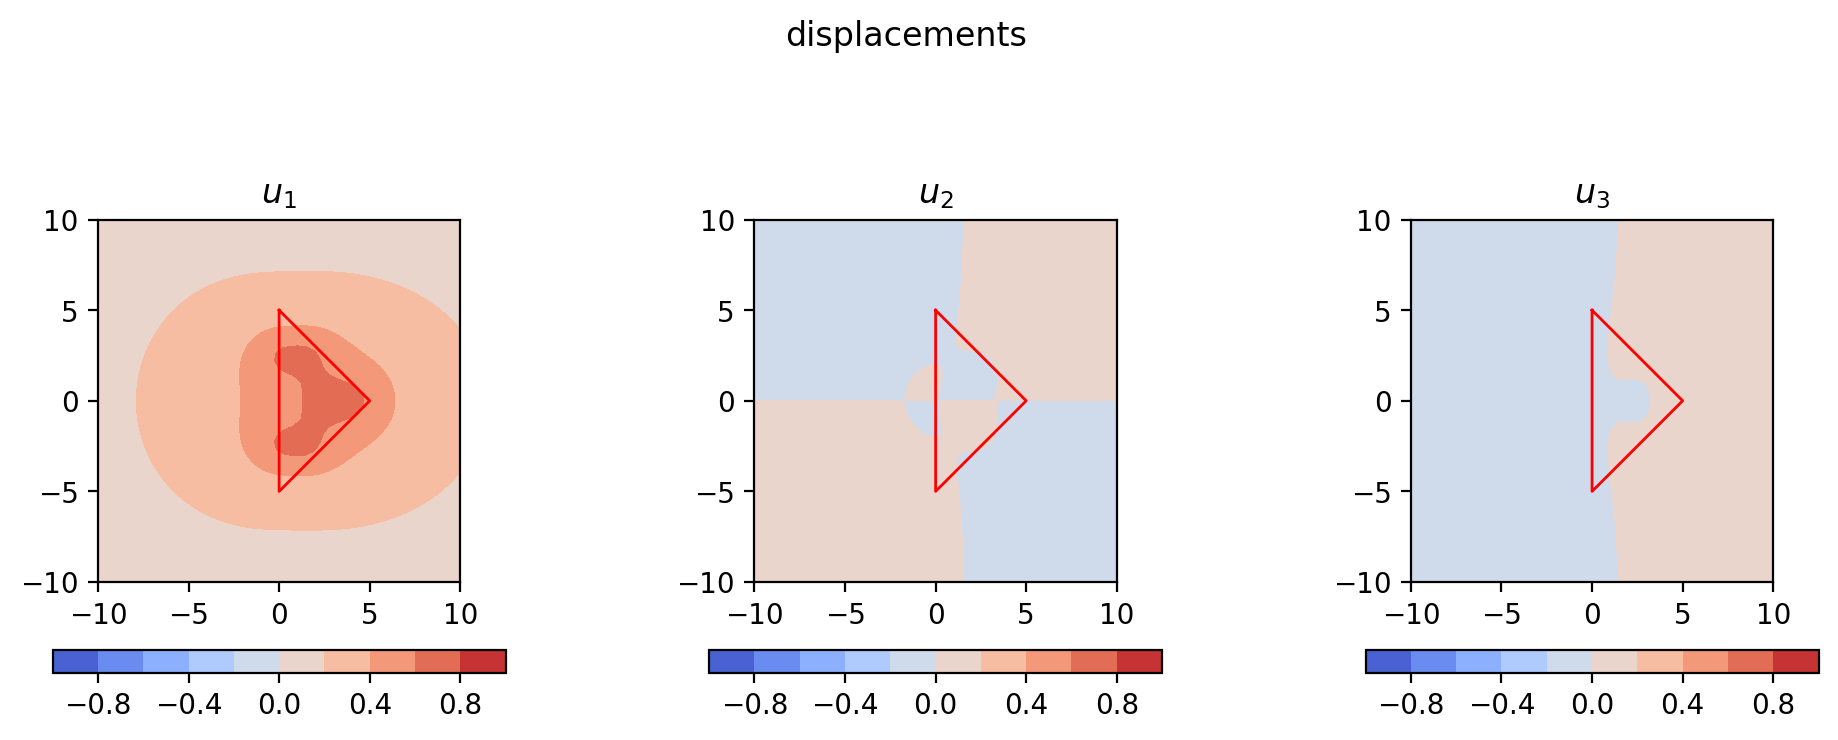

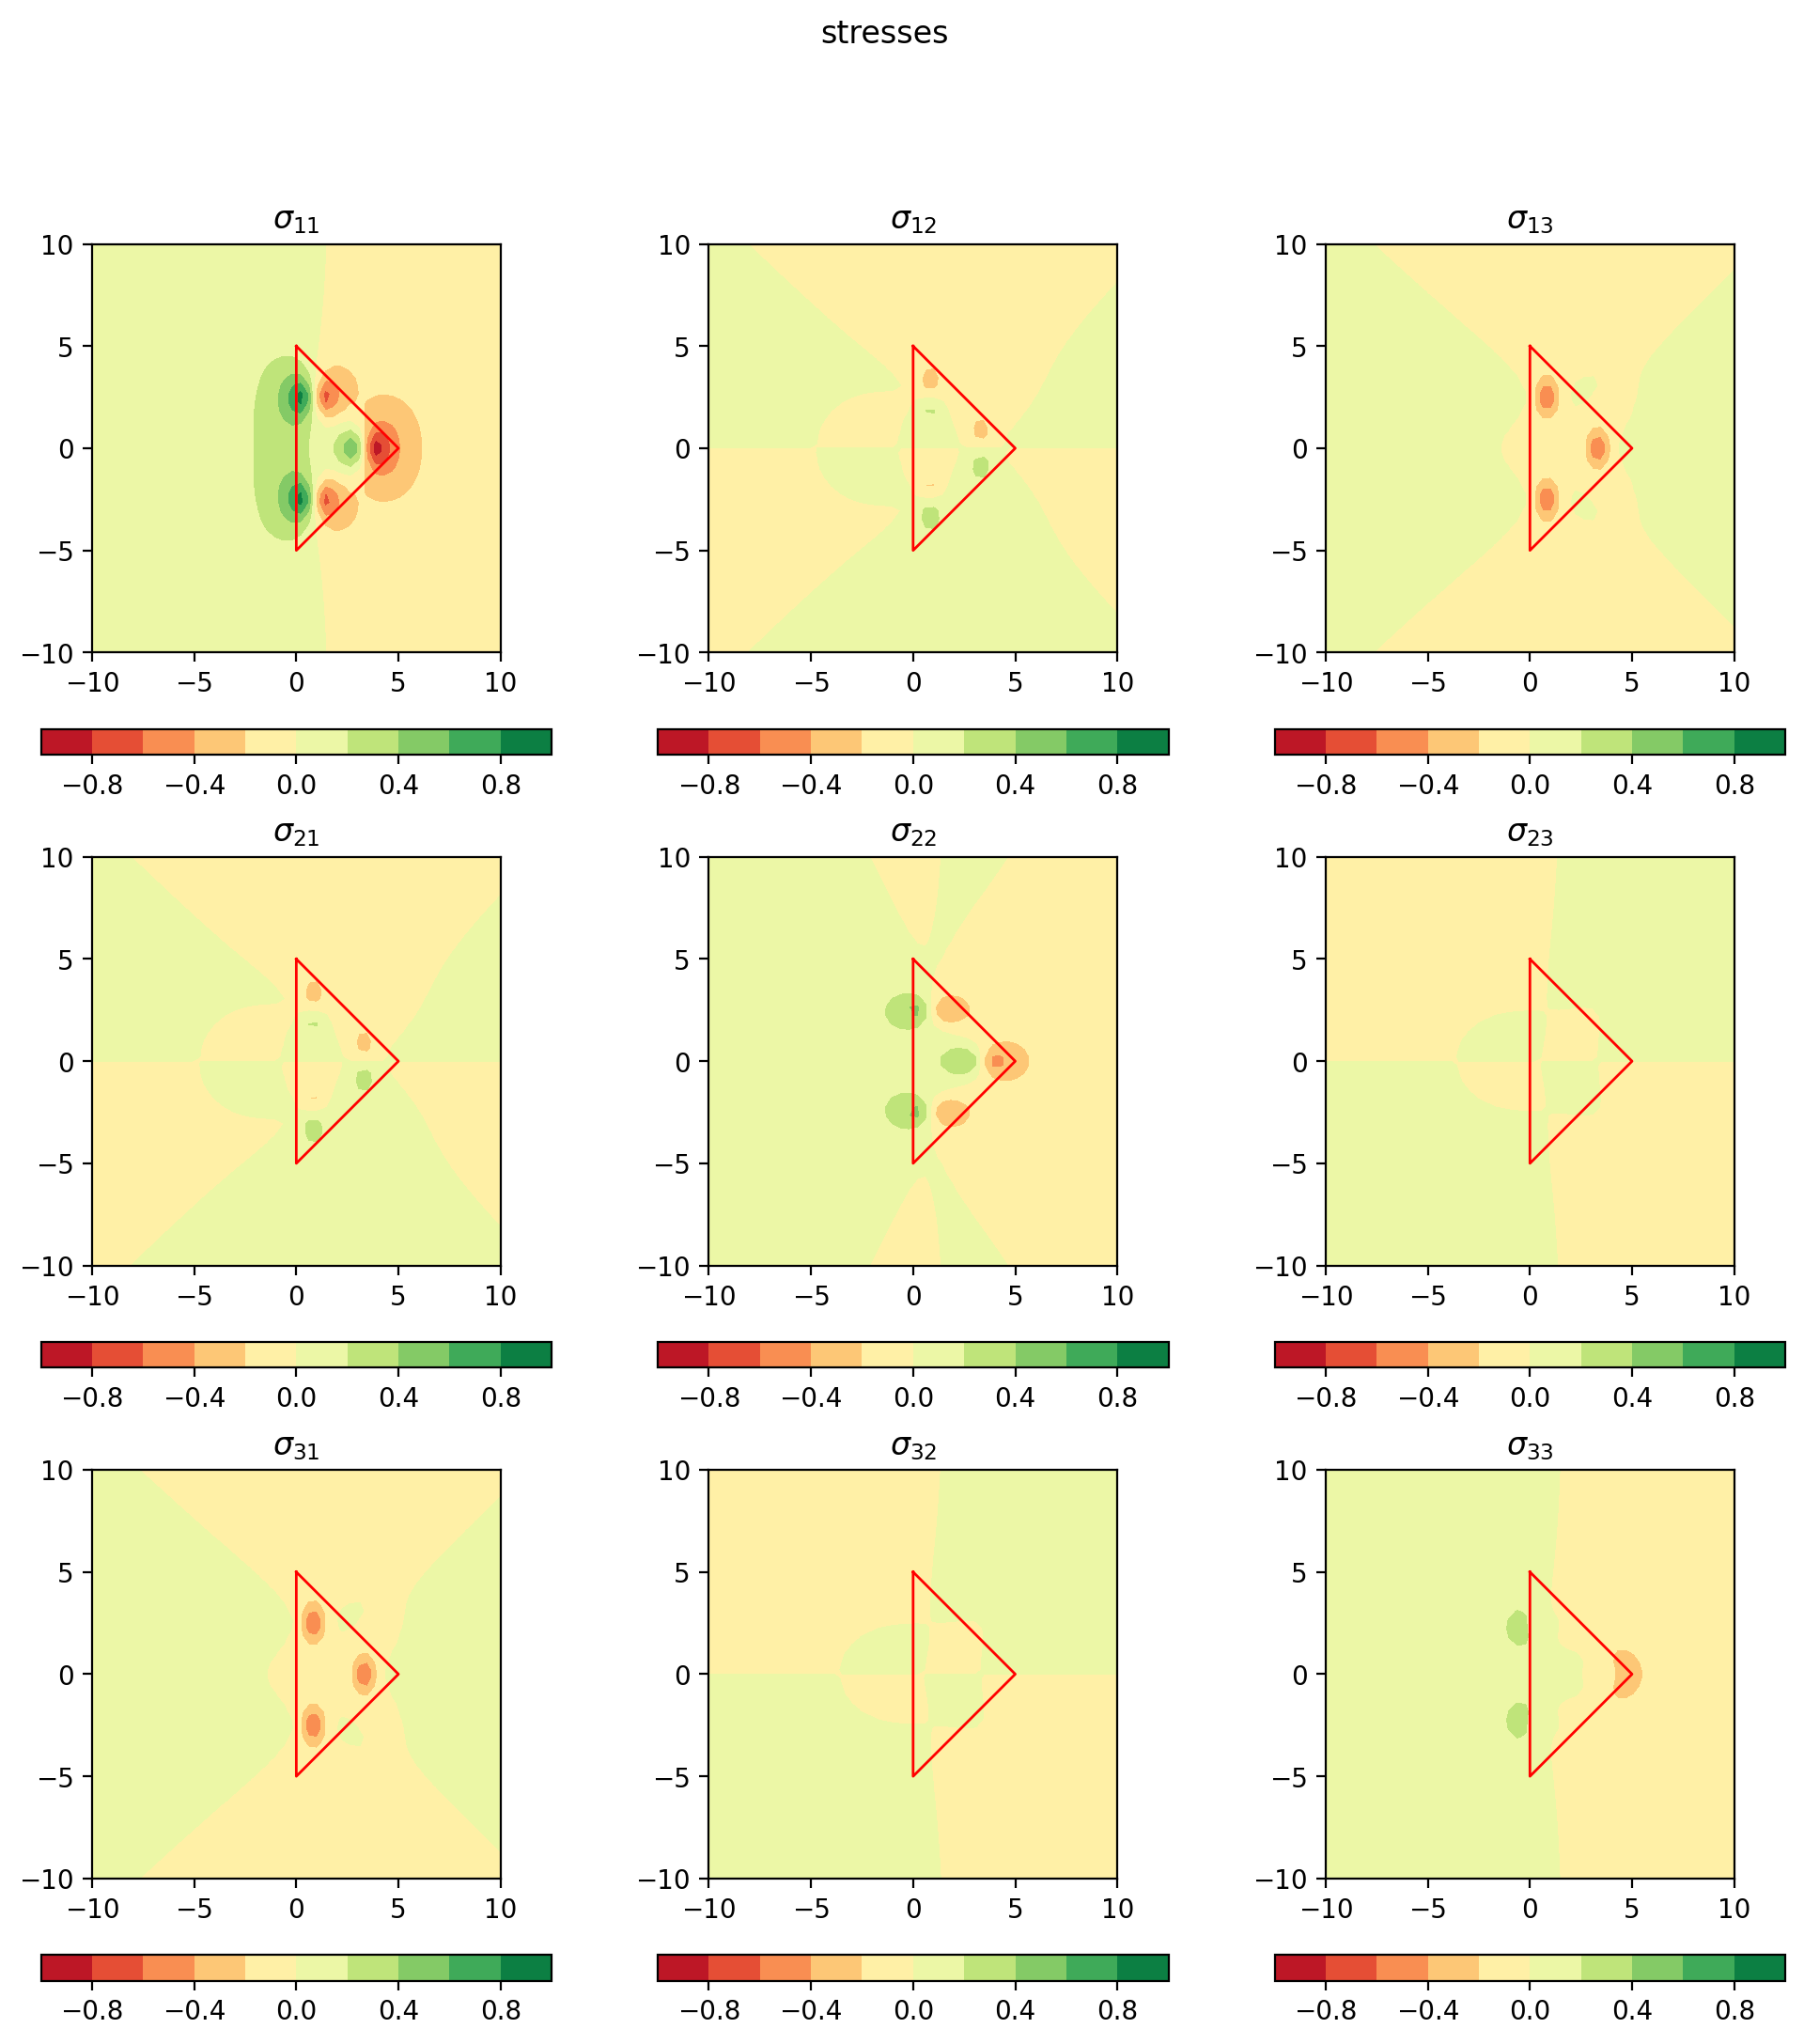

In [46]:
n = np.array([1.0, 0.0, 0.0])
u_field = compute_field(grid_x, grid_y, z_obs, vertices, n, stress_drop, mu, nu)
stress_field = compute_stress_field(
    grid_x, grid_y, z_obs, vertices, n, stress_drop, mu, nu
)
plot_all(grid_x, grid_y, u_field, stress_field, tri)

# Force in y-direction

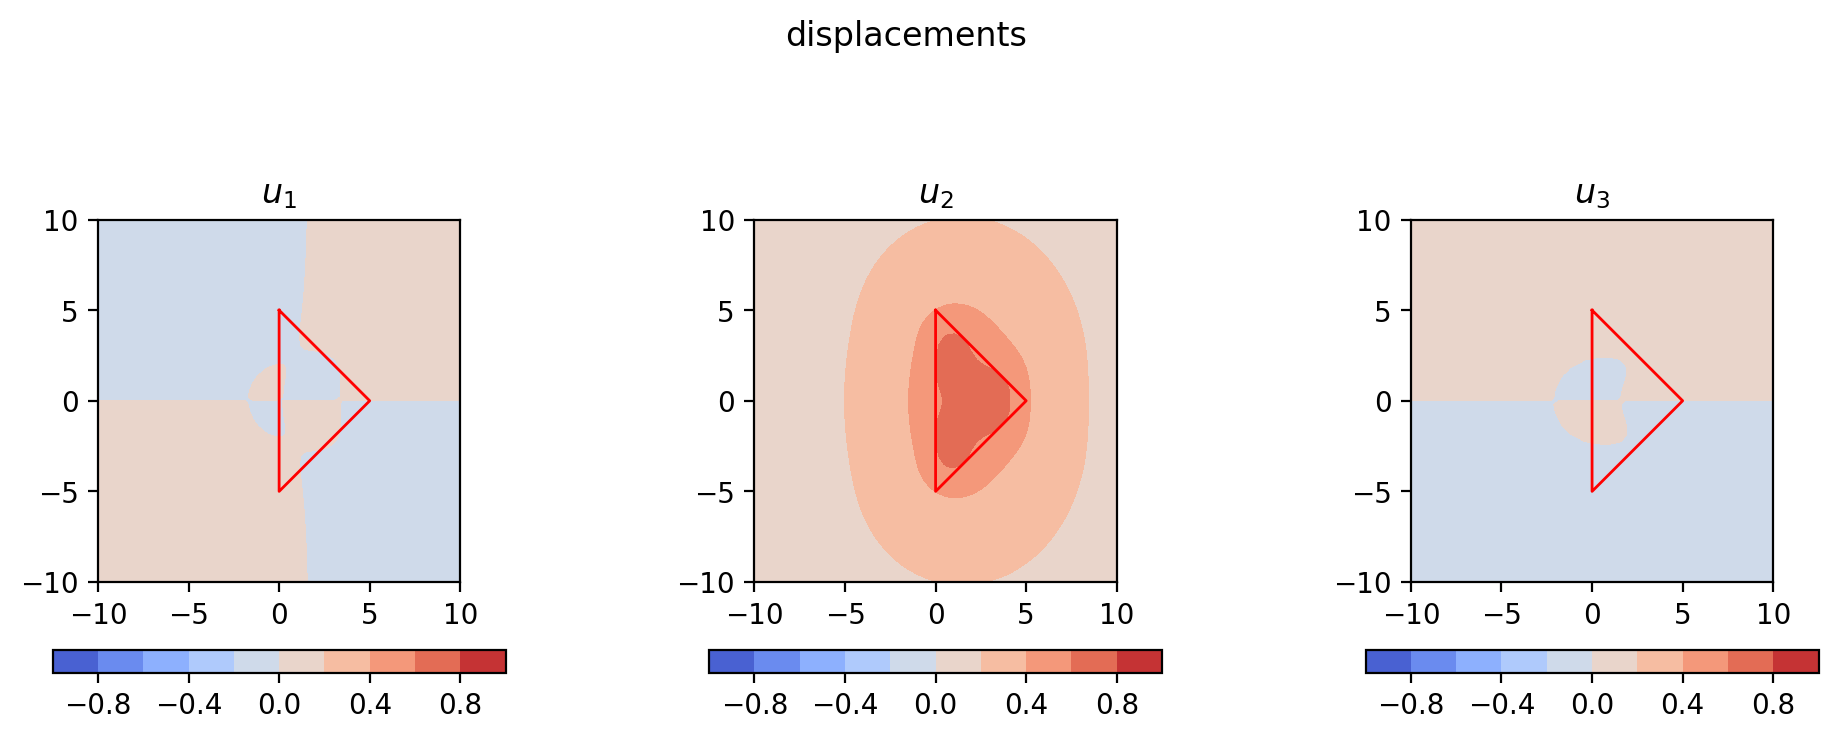

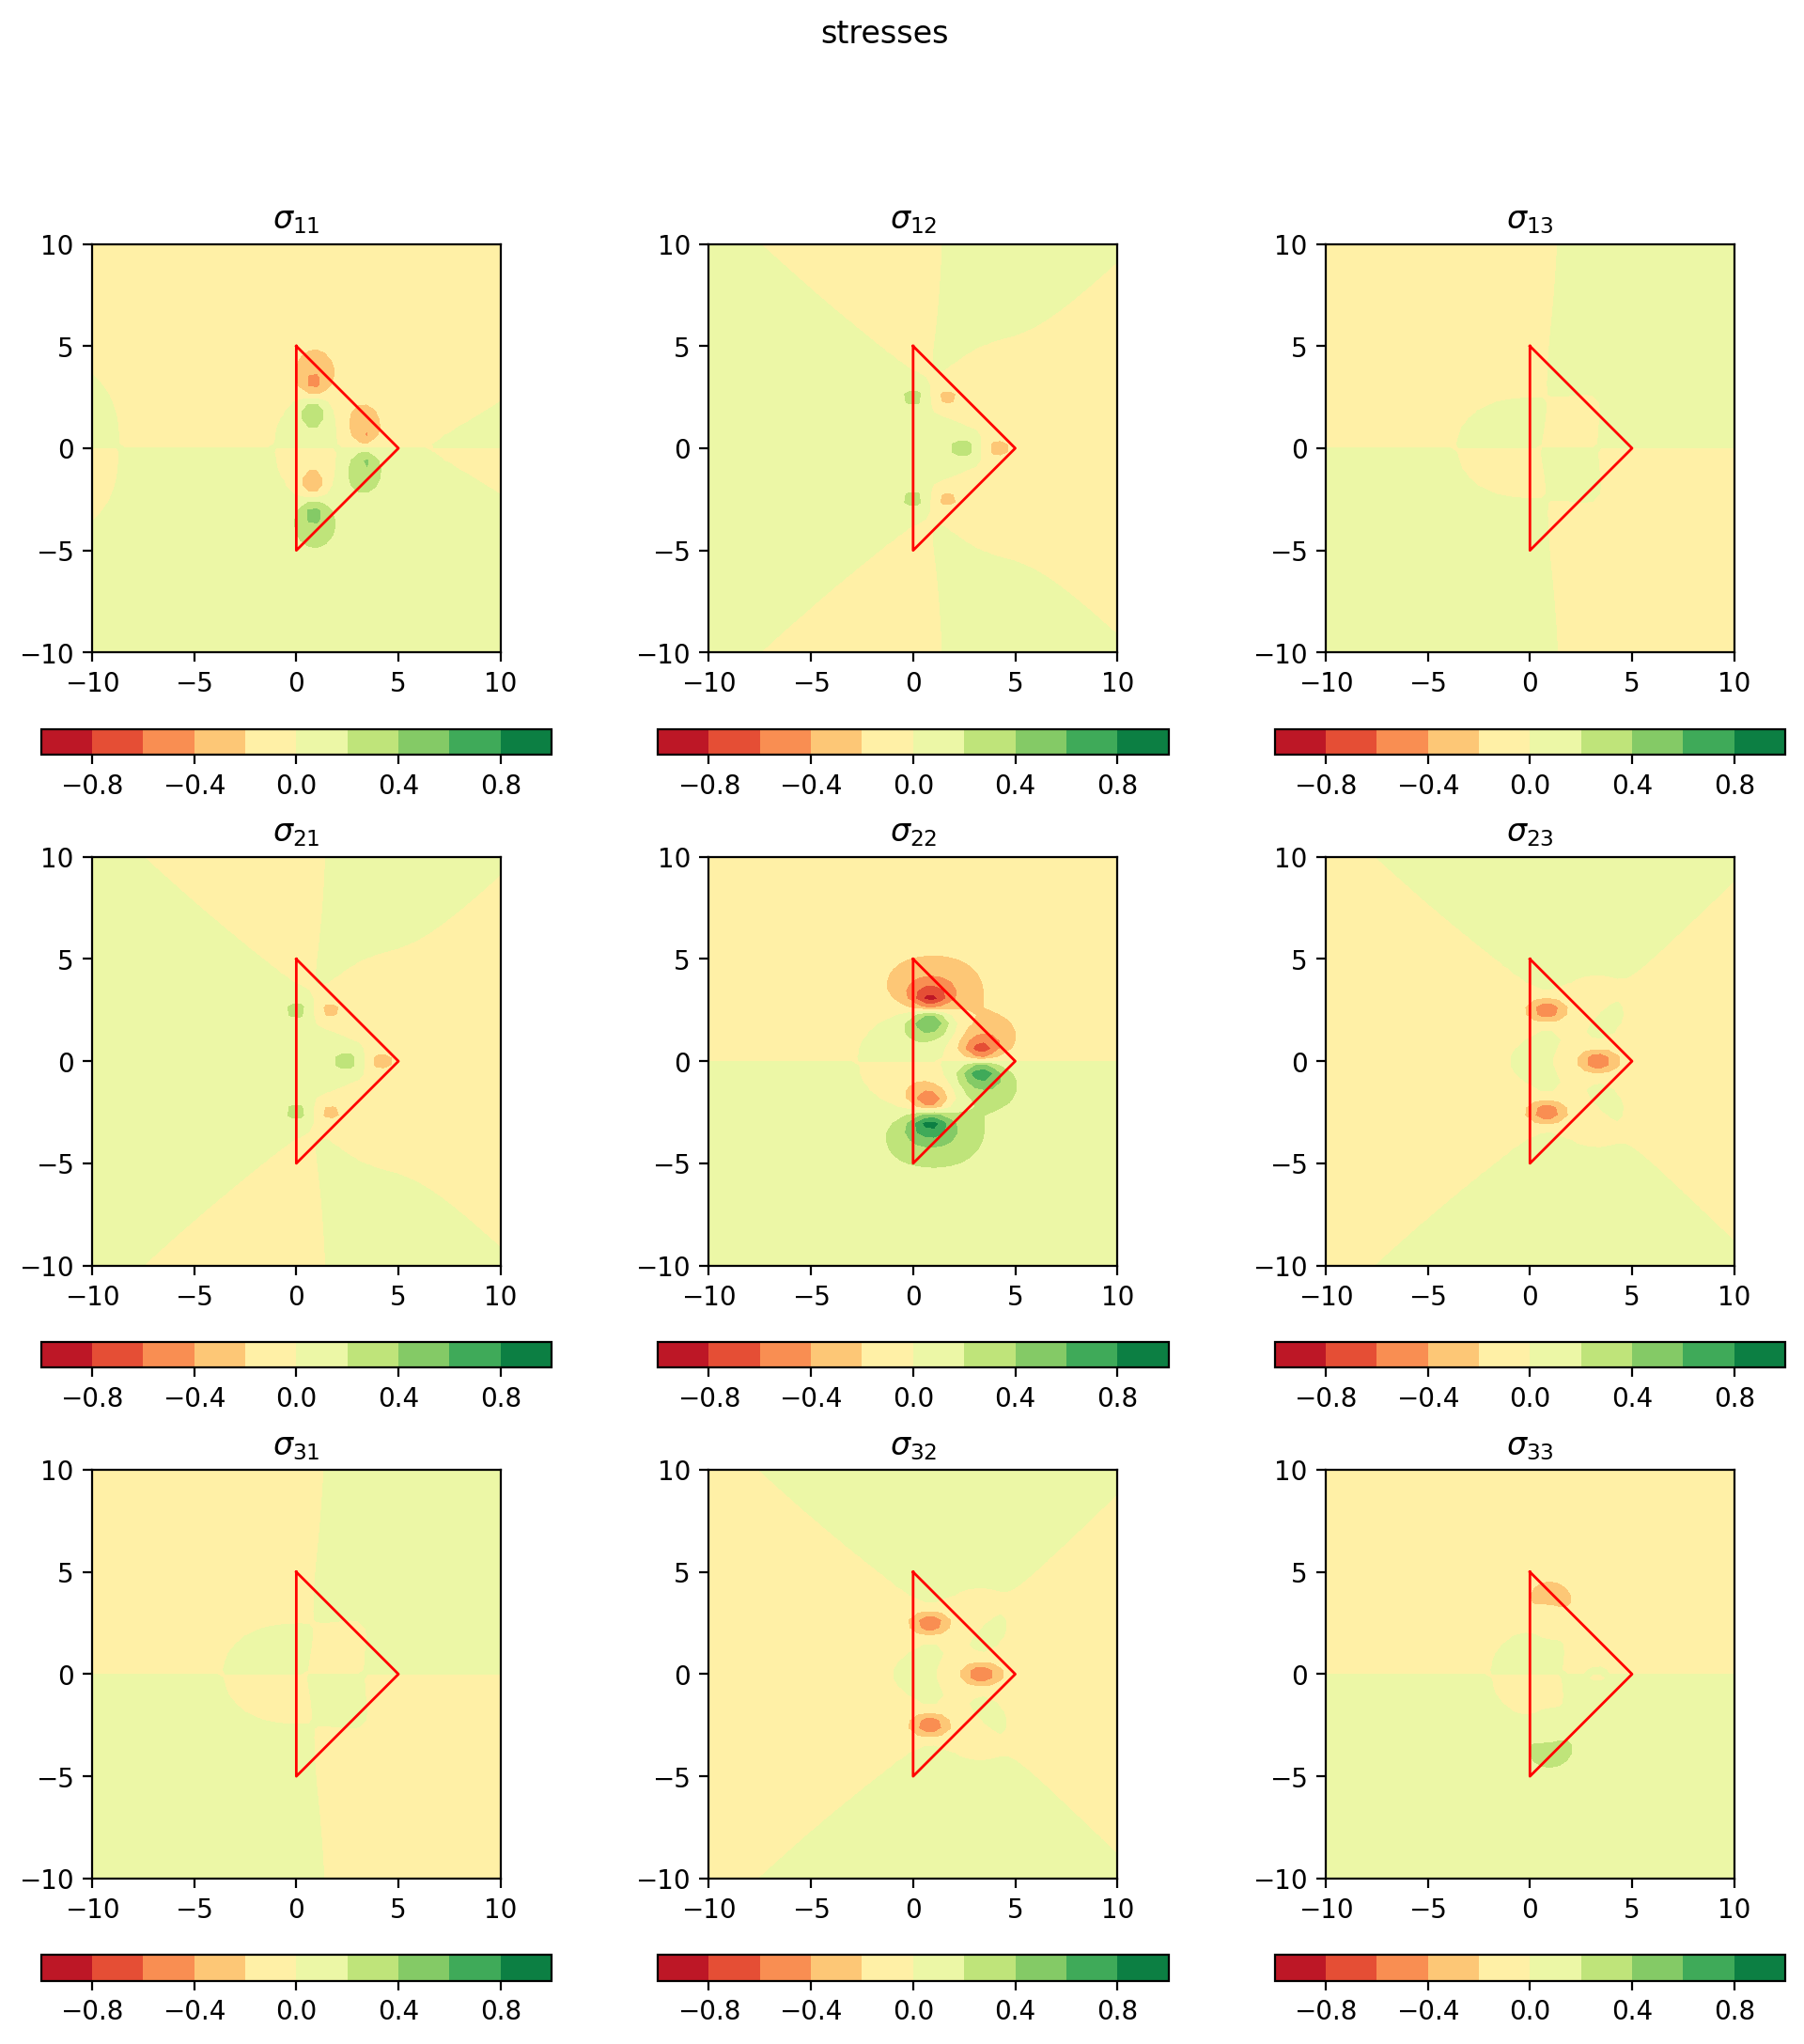

In [47]:
n = np.array([0.0, 1.0, 0.0])
u_field = compute_field(grid_x, grid_y, z_obs, vertices, n, stress_drop, mu, nu)
stress_field = compute_stress_field(
    grid_x, grid_y, z_obs, vertices, n, stress_drop, mu, nu
)
plot_all(grid_x, grid_y, u_field, stress_field, tri)

# Force in z-direction

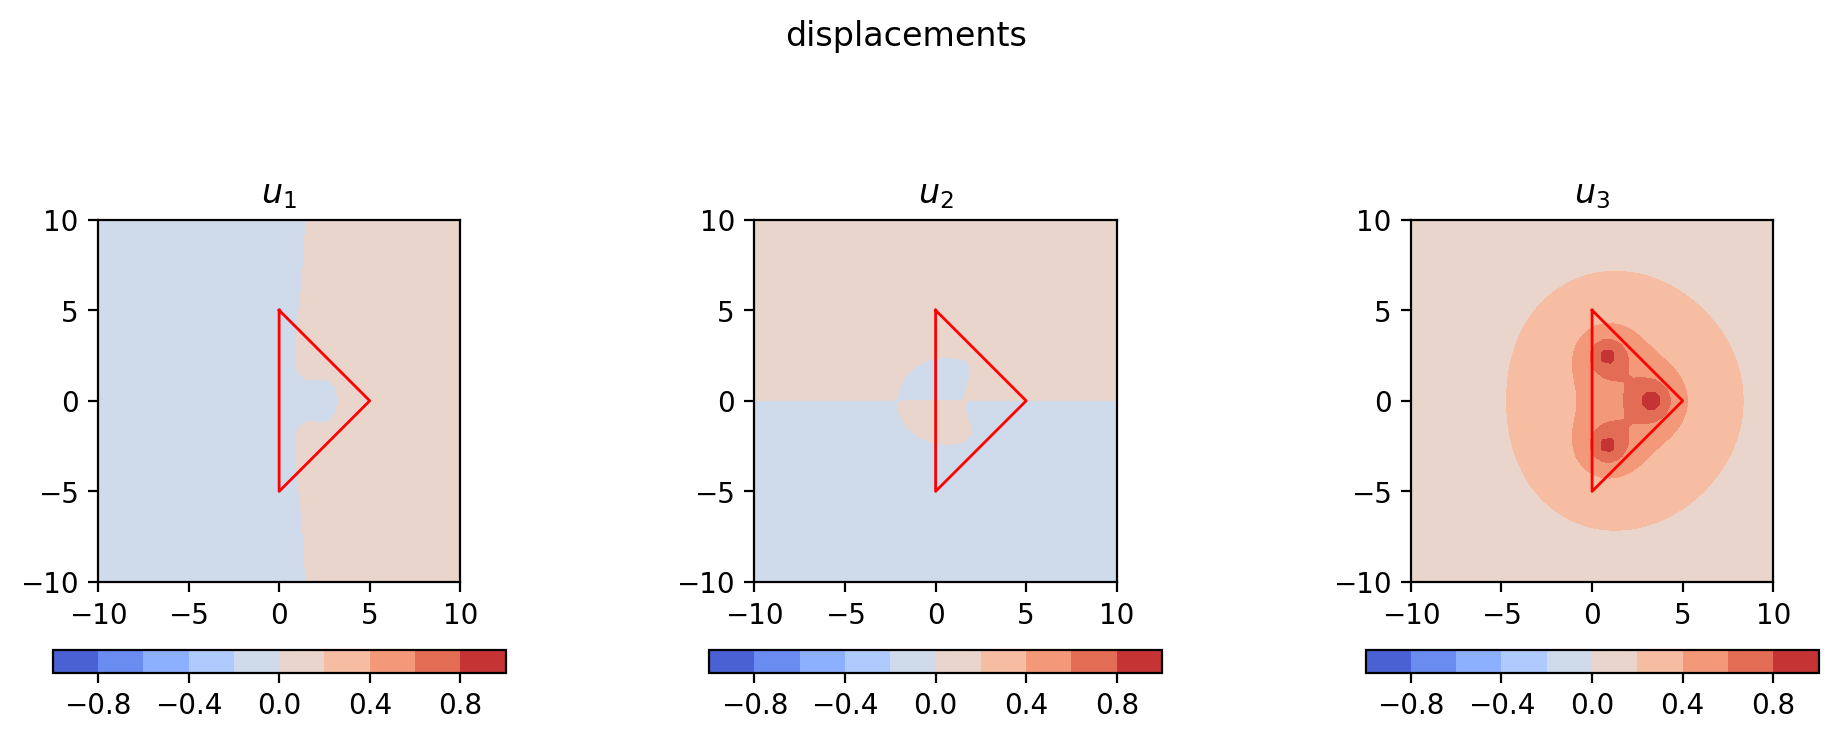

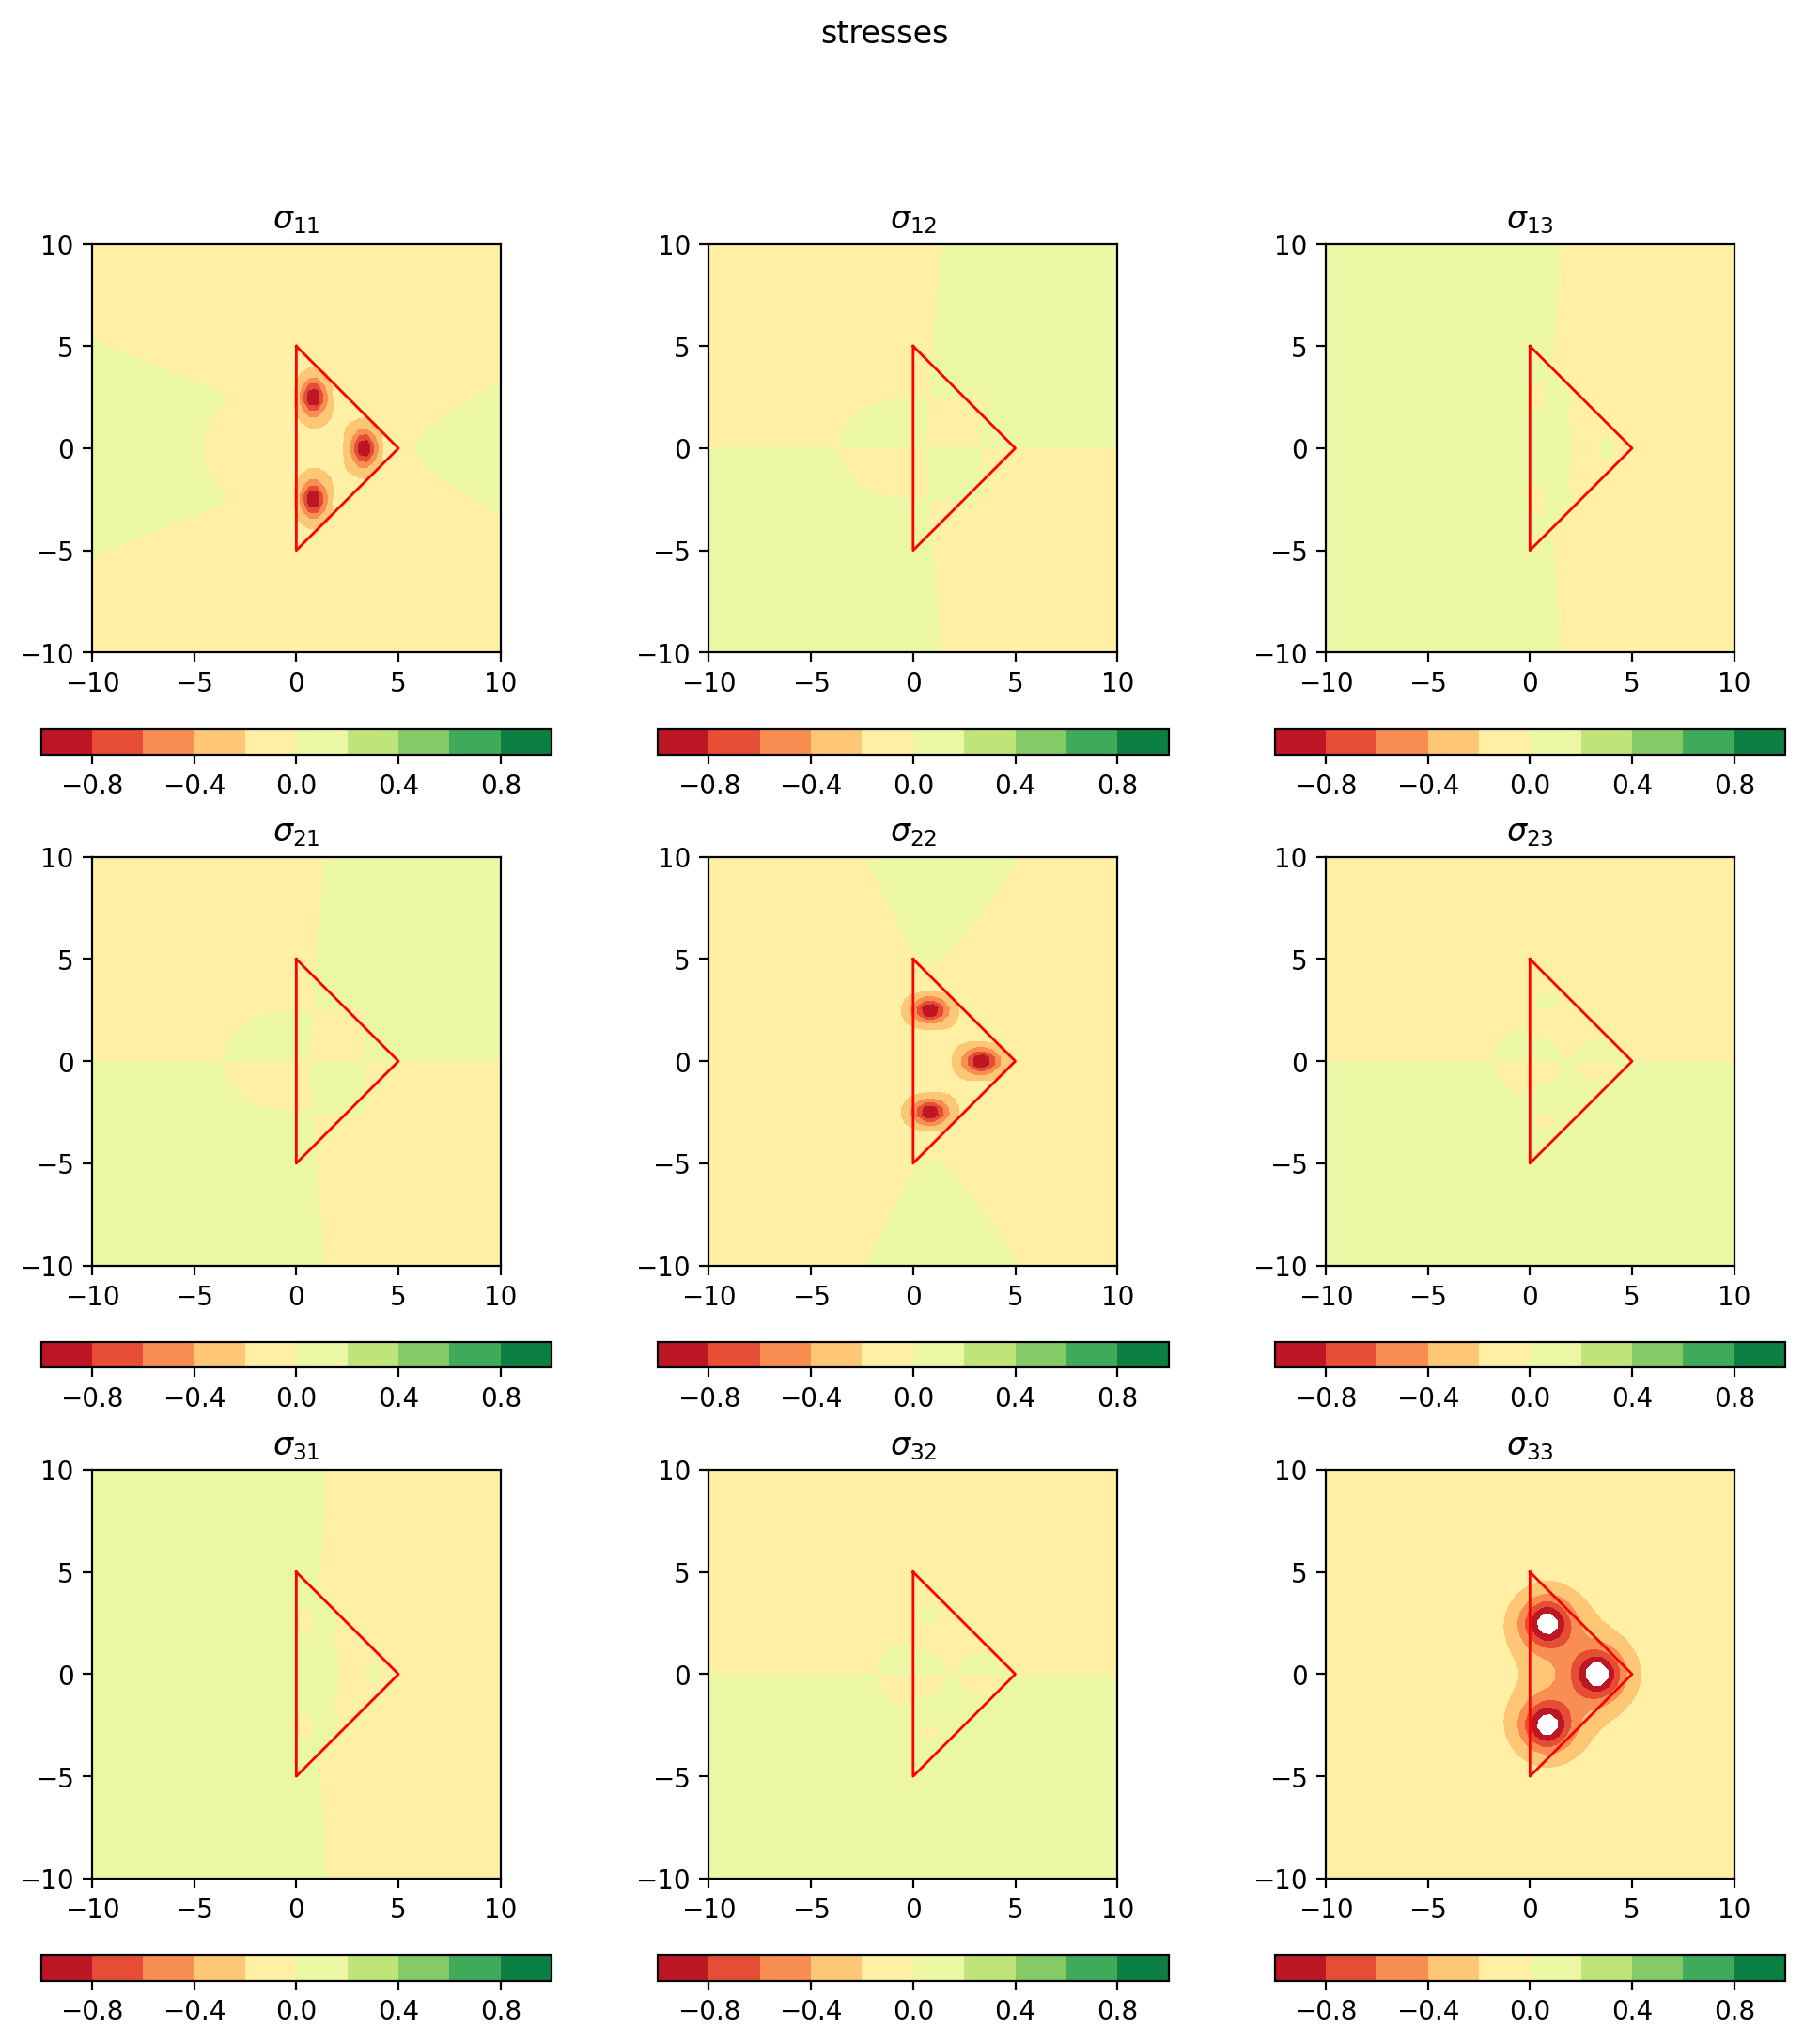

In [48]:
n = np.array([0.0, 0.0, 1.0])
u_field = compute_field(grid_x, grid_y, z_obs, vertices, n, stress_drop, mu, nu)
stress_field = compute_stress_field(
    grid_x, grid_y, z_obs, vertices, n, stress_drop, mu, nu
)
plot_all(grid_x, grid_y, u_field, stress_field, tri)